In [1]:
!pip install --upgrade pandas pyarrow
!pip install skforecast

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster

In [3]:
df = pd.read_parquet('bermejales.gzip')

# Muestra las primeras filas de la tabla para verificar
print(df.head())

              datetime         co      no2      o3  pm10     tmp      vv
0  2005-01-01 00:00:00  2269.0000  18.6667  2.5000   NaN  6.0000  0.3333
1  2005-01-01 01:00:00  2269.0000  18.6667  2.5000   NaN  6.0000  0.3333
2  2005-01-01 02:00:00  2024.6667  26.6667  7.5000   NaN  6.6667  1.0000
3  2005-01-01 03:00:00  2229.3333  19.6667  5.5000   NaN  6.1667  0.3333
4  2005-01-01 04:00:00  2096.1667  19.5000  4.6667   NaN  5.3333  0.8333


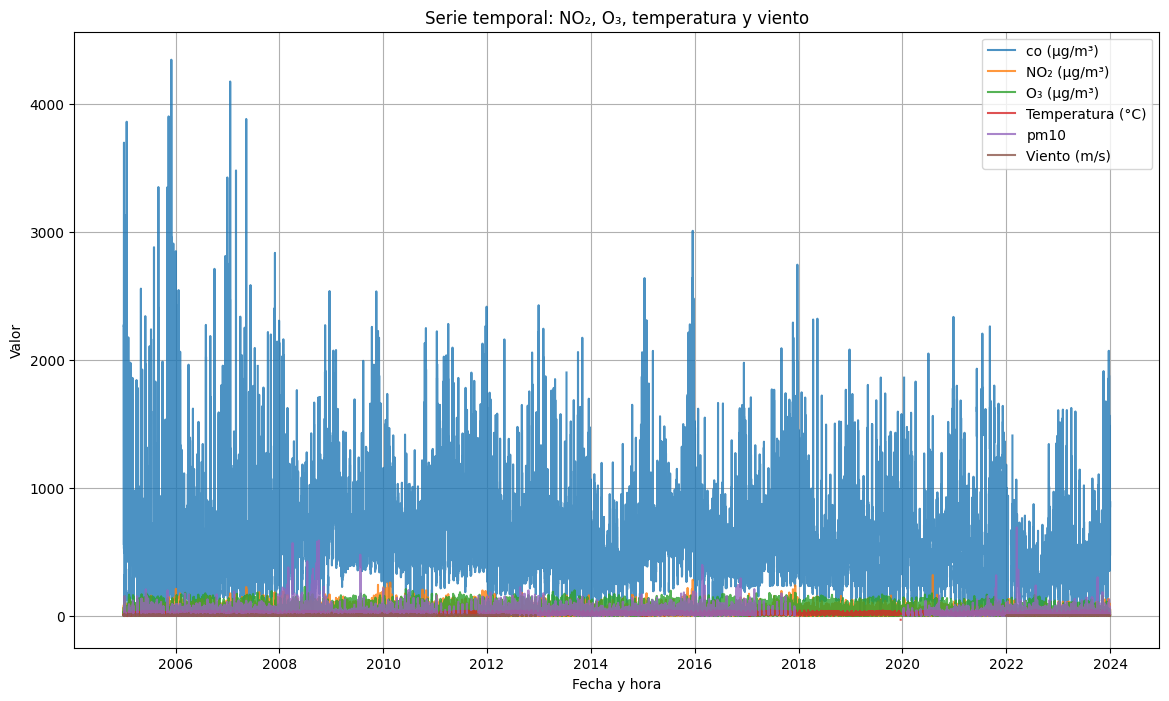

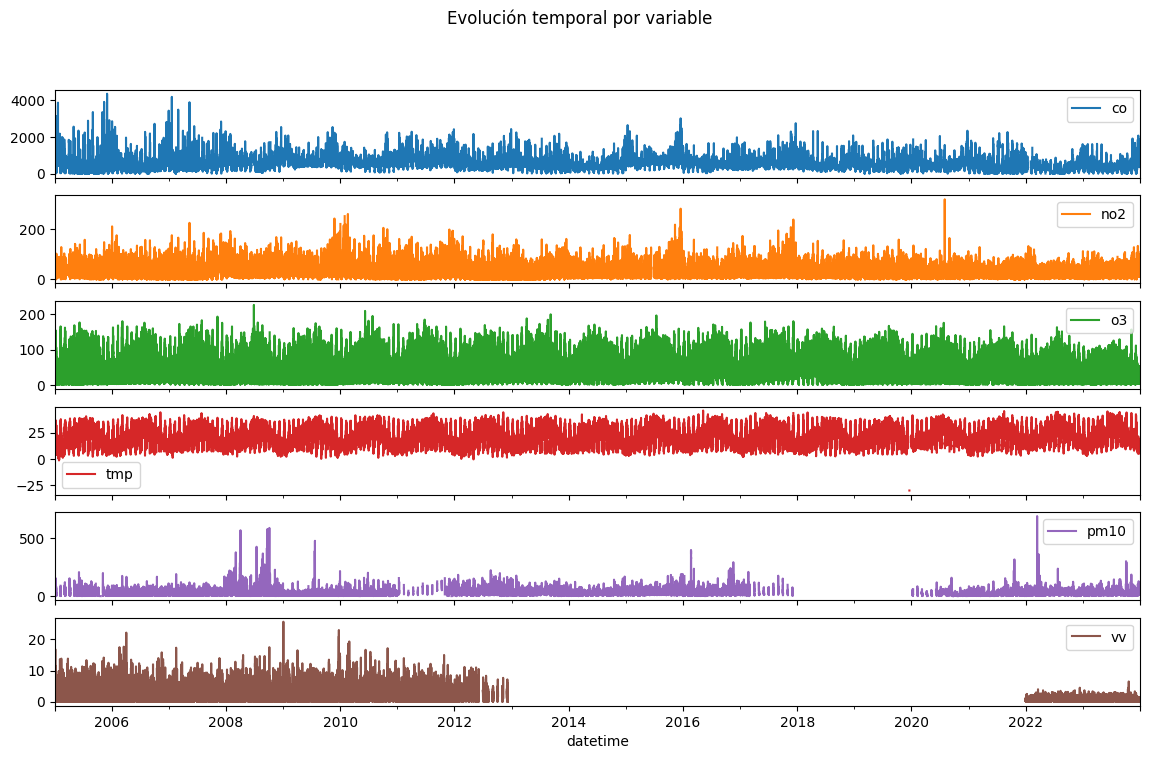

In [4]:
# --- 2. Convertir la columna datetime a tipo fecha ---
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')

# --- 3. Definir columna temporal como índice ---
df = df.set_index('datetime')

# --- 4. Visualización general ---
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['co'], label='co (µg/m³)', alpha=0.8)
plt.plot(df.index, df['no2'], label='NO₂ (µg/m³)', alpha=0.8)
plt.plot(df.index, df['o3'], label='O₃ (µg/m³)', alpha=0.8)
plt.plot(df.index, df['tmp'], label='Temperatura (°C)', alpha=0.8)
plt.plot(df.index, df['pm10'], label='pm10', alpha=0.8)
plt.plot(df.index, df['vv'], label='Viento (m/s)', alpha=0.8)
plt.title('Serie temporal: NO₂, O₃, temperatura y viento')
plt.xlabel('Fecha y hora')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

# --- 5. Subgráficos por variable ---
variables = ['co', 'no2', 'o3', 'tmp','pm10', 'vv']
df[variables].plot(subplots=True, figsize=(14, 8), sharex=True, title='Evolución temporal por variable')
plt.show()


Mostrando datos desde 2023-12-24 hasta 2023-12-31


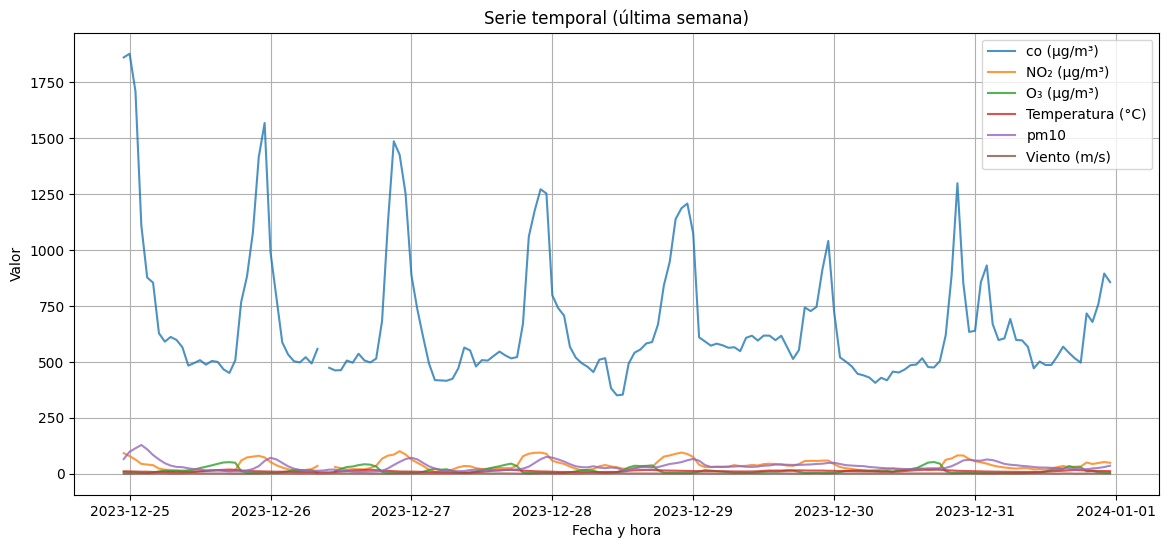

In [5]:
ultima_fecha = df.index.max()
inicio_semana = ultima_fecha - pd.Timedelta(days=7)
df_semana = df.loc[inicio_semana:ultima_fecha]

print(f"Mostrando datos desde {inicio_semana.date()} hasta {ultima_fecha.date()}")

# --- 🔹 Graficar las variables principales ---
plt.figure(figsize=(14, 6))
plt.plot(df_semana.index, df_semana['co'], label='co (µg/m³)', alpha=0.8)
plt.plot(df_semana.index, df_semana['no2'], label='NO₂ (µg/m³)', alpha=0.8)
plt.plot(df_semana.index, df_semana['o3'], label='O₃ (µg/m³)', alpha=0.8)
plt.plot(df_semana.index, df_semana['tmp'], label='Temperatura (°C)', alpha=0.8)
plt.plot(df_semana.index, df_semana['pm10'], label='pm10', alpha=0.8)
plt.plot(df_semana.index, df_semana['vv'], label='Viento (m/s)', alpha=0.8)
plt.title('Serie temporal (última semana)')
plt.xlabel('Fecha y hora')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
ultima_fecha = df.index.max()
inicio_2021 = ultima_fecha - pd.Timedelta(days=730)
df_year = df.loc[inicio_2021:ultima_fecha]

Vemos que CO tiene demasiados nulos, y vemos que además está en otra escala totalmente distinto. Por ello, y como contamos con muchas variables ecógenas ya, prescindiremos de ella.

### 2021 a 2023

In [11]:
df_last = df.truncate(before = '2022-01-01 00:00:00', after= '2023-12-31 23:00:00').drop(columns=['co'])

In [12]:
print("Frecuencia inferida:", pd.infer_freq(df_last.index))
# mostrar primeras/últimas filas y huecos
print(df_last.head())
print(df_last.tail())

Frecuencia inferida: h
                         no2       o3     pm10      tmp      vv
datetime                                                       
2022-01-01 00:00:00  24.0000  20.0000  39.6667  14.6667     NaN
2022-01-01 01:00:00  15.1667  23.5000  49.5000  14.5000  1.0000
2022-01-01 02:00:00  31.3333   6.8333  85.0000  13.1667  0.1667
2022-01-01 03:00:00  23.0000  14.6667  96.1667  13.0000  1.0000
2022-01-01 04:00:00   9.5000  25.1667  77.8333  13.0000  1.0000
                         no2       o3     pm10      tmp      vv
datetime                                                       
2023-12-31 19:00:00  50.1667  11.1667  20.1667  14.5000  0.6667
2023-12-31 20:00:00  43.5000  12.5000  23.5000  12.8333  0.8333
2023-12-31 21:00:00  47.6667   6.5000  26.0000  12.0000  0.8333
2023-12-31 22:00:00  52.3333   4.6667  29.8333  12.0000  0.5000
2023-12-31 23:00:00  48.8333   4.8333  35.8333  11.3333  0.5000


Vemos la frecuencia que es horaria.

In [27]:
# 4.1: Imputación rápida para huecos pequeños con interpolación por columna
df_interp = df_last.copy()
for col in df_interp.columns:
    # interpolación temporal; limit=6 -> no imputa tramos mayores a 6 horas (ajusta)
    df_interp[col] = df_interp[col].interpolate(method='time', limit=6)

# 4.2: Para huecos más largos, usar IterativeImputer (e.g. BayesianRidge pred) o KNN
# crear features de tiempo para ayudar a imputar

df_imp = df_interp.copy()
df_imp['hour'] = df_imp.index.hour
df_imp['dayofweek'] = df_imp.index.dayofweek
df_imp['month'] = df_imp.index.month

# Imputador iterativo (puede ser más robusto que KNN)
imp = IterativeImputer(random_state=0, max_iter=10)
cols = ['no2','o3','pm10','tmp','vv','hour','dayofweek','month']
imputed = imp.fit_transform(df_imp[cols])
df_imputed = pd.DataFrame(imputed, index=df_imp.index, columns=cols)
df_imputed = df_imputed.drop(columns=['hour','dayofweek','month'])

In [28]:
df_imputed.isna().sum()

no2     0
o3      0
pm10    0
tmp     0
vv      0
dtype: int64

### Serie con nulos imputados

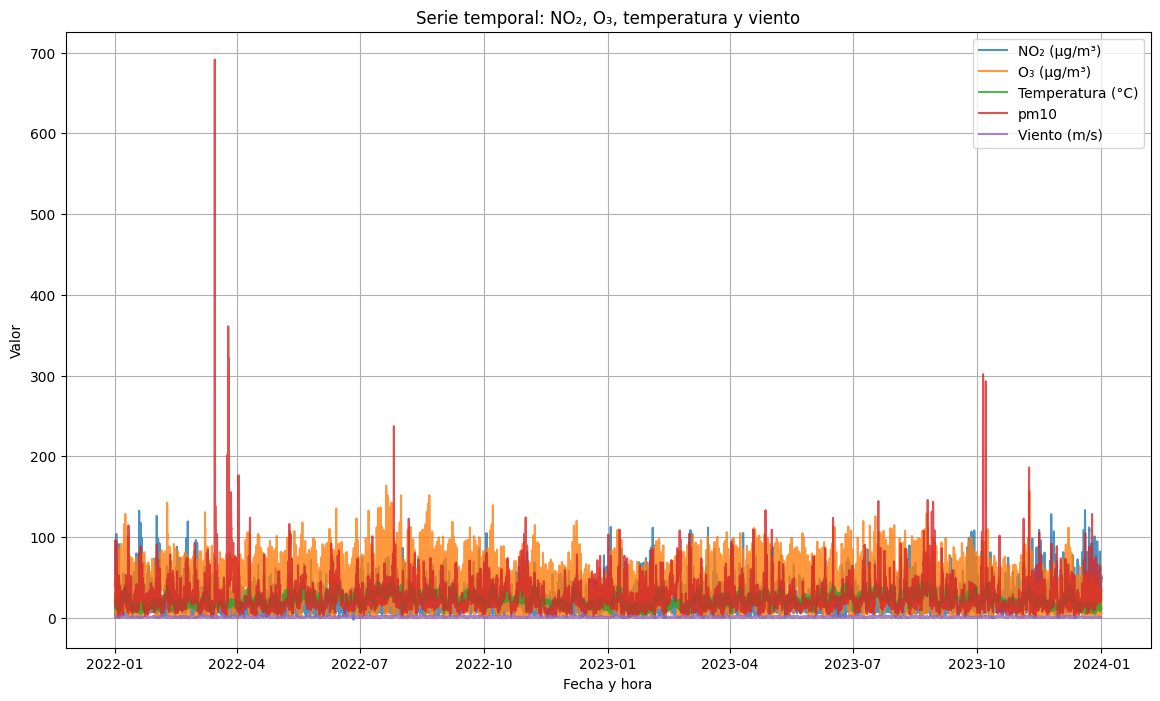

In [29]:
plt.figure(figsize=(14, 8))
plt.plot(df_imputed.index, df_imputed['no2'], label='NO₂ (µg/m³)', alpha=0.8)
plt.plot(df_imputed.index, df_imputed['o3'], label='O₃ (µg/m³)', alpha=0.8)
plt.plot(df_imputed.index, df_imputed['tmp'], label='Temperatura (°C)', alpha=0.8)
plt.plot(df_imputed.index, df_imputed['pm10'], label='pm10', alpha=0.8)
plt.plot(df_imputed.index, df_imputed['vv'], label='Viento (m/s)', alpha=0.8)
plt.title('Serie temporal: NO₂, O₃, temperatura y viento')
plt.xlabel('Fecha y hora')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
def cap_outliers(s, k=1.5):
    q1 = df_imputed[s].quantile(0.25)
    q3 = df_imputed[s].quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    outliers = df_imputed[(df_imputed[s] < lower) | (df_imputed[s] > upper)]
    print('Outliers en '+str(s)+ ' ' + str(len(outliers)))

cols_to_check = ['no2', 'pm10', 'tmp', 'vv', 'o3']
for col in cols_to_check:
    cap_outliers(col)

Outliers en no2 885
Outliers en pm10 1019
Outliers en tmp 40
Outliers en vv 3471
Outliers en o3 66


### Modelo con variables endógenas:

In [31]:
y = df_imputed.drop(columns=['vv','tmp','no2','pm10'])

In [32]:
def generar_atributos_desfase(ts_data, var, max_lag):
    """
    Crea columnas var_lag1, var_lag2, ..., var_lag{k} con shift(t).
    ts_data: DataFrame con índice temporal
    var:     nombre de la columna base (p.ej., 'Nivel')
    max_lag: número máximo de retardos
    """
    for t in range(1, max_lag + 1):
        ts_data[f'{var}_lag{t}'] = ts_data[var].shift(t)
    return ts_data

df = generar_atributos_desfase(y.copy(), 'o3', max_lag=10)
display(df.tail(10))

,o3,o3_lag1,o3_lag2,o3_lag3,o3_lag4,o3_lag5,o3_lag6,o3_lag7,o3_lag8,o3_lag9,o3_lag10
datetime,,,,,,,,,,,
2023-12-31 14:00:00,19.3333,16.5000,9.6667,5.6667,5.0000,3.1667,3.0000,3.1667,3.0000,3.1667,2.8333
2023-12-31 15:00:00,21.5000,19.3333,16.5000,9.6667,5.6667,5.0000,3.1667,3.0000,3.1667,3.0000,3.1667
2023-12-31 16:00:00,34.5000,21.5000,19.3333,16.5000,9.6667,5.6667,5.0000,3.1667,3.0000,3.1667,3.0000
2023-12-31 17:00:00,27.6667,34.5000,21.5000,19.3333,16.5000,9.6667,5.6667,5.0000,3.1667,3.0000,3.1667
2023-12-31 18:00:00,29.0000,27.6667,34.5000,21.5000,19.3333,16.5000,9.6667,5.6667,5.0000,3.1667,3.0000
2023-12-31 19:00:00,11.1667,29.0000,27.6667,34.5000,21.5000,19.3333,16.5000,9.6667,5.6667,5.0000,3.1667
2023-12-31 20:00:00,12.5000,11.1667,29.0000,27.6667,34.5000,21.5000,19.3333,16.5000,9.6667,5.6667,5.0000
2023-12-31 21:00:00,6.5000,12.5000,11.1667,29.0000,27.6667,34.5000,21.5000,19.3333,16.5000,9.6667,5.6667
2023-12-31 22:00:00,4.6667,6.5000,12.5000,11.1667,29.0000,27.6667,34.5000,21.5000,19.3333,16.5000,9.6667


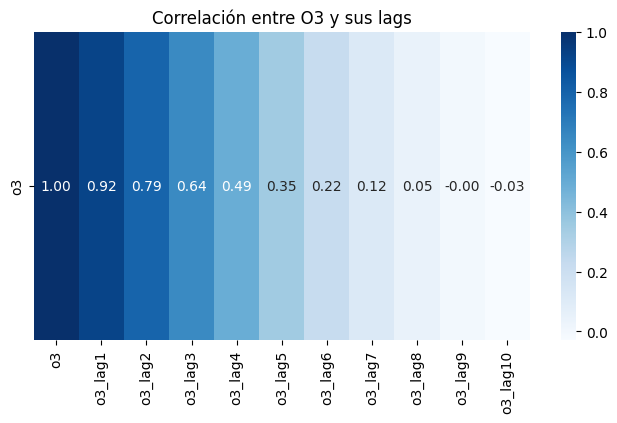

In [35]:
lags_cols = [c for c in df.columns if c.startswith('o3_lag')]
corr = df[['o3'] + lags_cols].dropna().corr()['o3'].sort_values(ascending=False)
corr

# 5) Mapa de calor de correlaciones (Nivel vs. sus lags)
plt.figure(figsize=(8, 4))
sns.heatmap(
    df[['o3'] + lags_cols].dropna().corr()[['o3']].T,
    annot=True, cmap='Blues', fmt=".2f"
)
plt.title('Correlación entre O3 y sus lags')
plt.show()

## Modelo autoregresivo sin lags:

In [36]:
y = df_imputed['o3'].astype(float)

In [65]:
y

datetime
2022-01-01 00:00:00    20.0000
2022-01-01 01:00:00    23.5000
2022-01-01 02:00:00     6.8333
2022-01-01 03:00:00    14.6667
2022-01-01 04:00:00    25.1667
                        ...   
2023-12-31 19:00:00    11.1667
2023-12-31 20:00:00    12.5000
2023-12-31 21:00:00     6.5000
2023-12-31 22:00:00     4.6667
2023-12-31 23:00:00     4.8333
Name: o3, Length: 17520, dtype: float64

train:(15768,), valid:(876,), test:(876,)


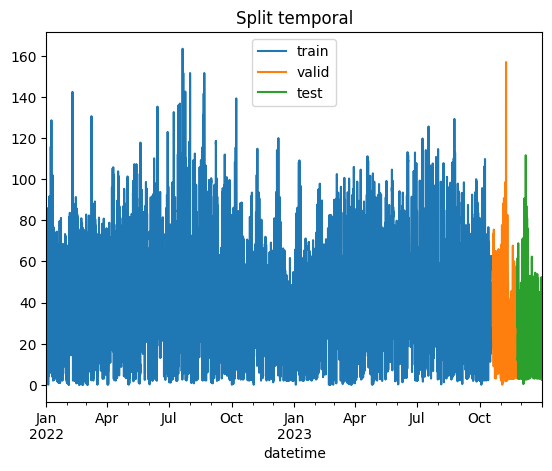

In [37]:
# 5) Split y CV
n = len(y)
train_end = int(0.90*n)
valid_end = int(0.95*n)

y_train = y.iloc[:train_end]
y_valid = y.iloc[train_end:valid_end]
y_test  = y.iloc[valid_end:]

print(f"train:{y_train.shape}, valid:{y_valid.shape}, test:{y_test.shape}")

ax = y_train.plot(label='train')
y_valid.plot(ax=ax, label='valid')
y_test.plot(ax=ax, label='test', title='Split temporal')
ax.legend(); plt.show()

In [41]:
!pip install statsmodels

  Using cached statsmodels-0.14.5-cp312-cp312-win_amd64.whl.metadata (9.8 kB)
  Using cached patsy-1.0.2-py2.py3-none-any.whl.metadata (3.6 kB)
Using cached statsmodels-0.14.5-cp312-cp312-win_amd64.whl (9.6 MB)
Using cached patsy-1.0.2-py2.py3-none-any.whl (233 kB)

   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [st

In [42]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


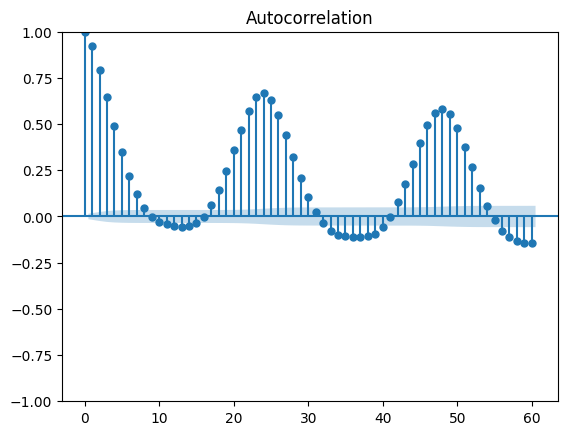

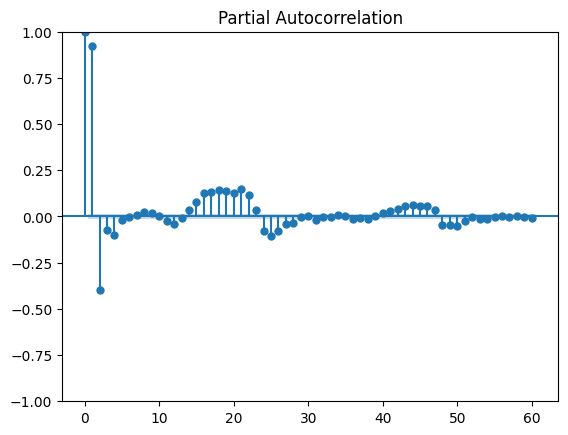

In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(y, lags=60)
plot_pacf(y, lags=60)
plt.show()

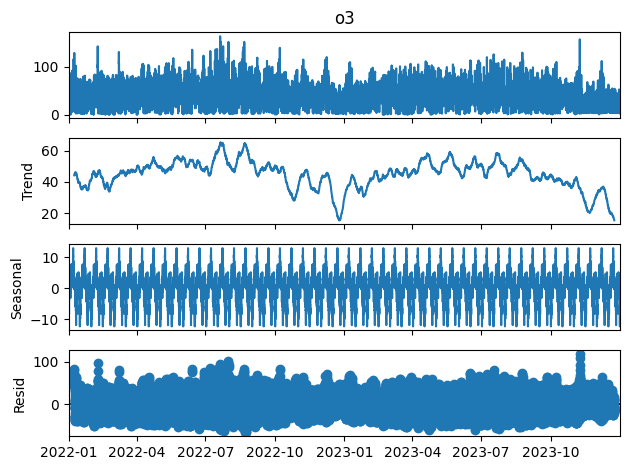

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y, model='additive', period=365)
decomposition.plot()
plt.show()

Esto indica que la estacionalidad dominante es semanal (≈7 días), no anual.

In [71]:
HORIZON = 10 
def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))